In [1]:
# =============================================================================
# CELL 1: Training Setup and Imports
# =============================================================================
"""
Historical Image Colorization - Model Training Notebook
This notebook trains the U-Net model for historical image colorization
"""

import os
import sys
import time
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Add src directory to path
sys.path.append('../')

# FIXED: Import all required functions
from src.dataset import create_dataloaders
from src.model import create_model
from src.train import HistoricalColorizationTrainer, ColorizationLoss
from src.utils import save_comparison_image, save_checkpoint, lab_to_rgb

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("✓ Training setup complete!")

Using device: cpu
✓ Training setup complete!


In [3]:
# =============================================================================
# CELL 2: Configuration and Hyperparameters
# =============================================================================

# Training configuration - FIXED: Define config at global scope
config = {
    # Data paths
    'base_dir': 'D:/colorization_task2/historical-colorization/colorization',
    'train_data_dir': 'D:/colorization_task2/historical-colorization/colorization/data/train',
    'val_data_dir': 'D:/colorization_task2/historical-colorization/colorization/data/validation',
    
    # Model parameters
    'use_period_embedding': True,
    'image_size': 256,
    
    # Training hyperparameters
    'batch_size': 4 if device.type == 'cpu' else 8,  # Adjust based on memory
    'num_epochs': 50,  # Start with fewer epochs for testing
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'lr_step_size': 20,
    'lr_gamma': 0.5,
    
    # Loss parameters
    'loss_alpha': 1.0,  # L1 loss weight
    'loss_beta': 0.1,   # Smoothness loss weight
    
    # Historical period
    'period': '1920s',
    
    # Output directories
    'checkpoint_dir': 'D:/colorization_task2/historical-colorization/colorization/checkpoints',
    'sample_dir': 'D:/colorization_task2/historical-colorization/colorization/outputs/samples',
    'log_dir': 'D:/colorization_task2/historical-colorization/colorization/logs',
    'models_dir': 'D:/colorization_task2/historical-colorization/colorization/models',
    
    # Data loading
    'num_workers': 2 if device.type == 'cpu' else 4,
    
    # Logging
    'log_interval': 10,
    'save_samples_interval': 5,
    'checkpoint_interval': 10
}

# Create output directories
for dir_key in ['checkpoint_dir', 'sample_dir', 'log_dir', 'models_dir']:
    os.makedirs(config[dir_key], exist_ok=True)

print("📋 TRAINING CONFIGURATION")
print("=" * 40)
for key, value in config.items():
    if not key.endswith('_dir'):
        print(f"{key}: {value}")
print()

# Save configuration
config_save_path = os.path.join(config['models_dir'], 'training_config.yaml')
with open(config_save_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)
print(f"✓ Configuration saved to: {config_save_path}")


📋 TRAINING CONFIGURATION
use_period_embedding: True
image_size: 256
batch_size: 4
num_epochs: 50
learning_rate: 0.001
weight_decay: 1e-05
lr_step_size: 20
lr_gamma: 0.5
loss_alpha: 1.0
loss_beta: 0.1
period: 1920s
num_workers: 2
log_interval: 10
save_samples_interval: 5
checkpoint_interval: 10

✓ Configuration saved to: D:/colorization_task2/historical-colorization/colorization/models\training_config.yaml


📂 Loading datasets...
Found 4 images for period: 1920s
Found 1 images for period: 1920s
Training samples: 4
Validation samples: 1
Training batches: 1
Validation batches: 1
✓ Data loaders created successfully!
Training batches: 1
Validation batches: 1

🔍 Testing data loader...


D:\colorization_task2\historical-colorization\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch keys: dict_keys(['L', 'ab', 'rgb', 'period', 'filename'])
L channel shape: torch.Size([4, 1, 256, 256])
AB channels shape: torch.Size([4, 2, 256, 256])
RGB shape: torch.Size([4, 3, 256, 256])
Periods: ['1920s', '1920s', '1920s']...


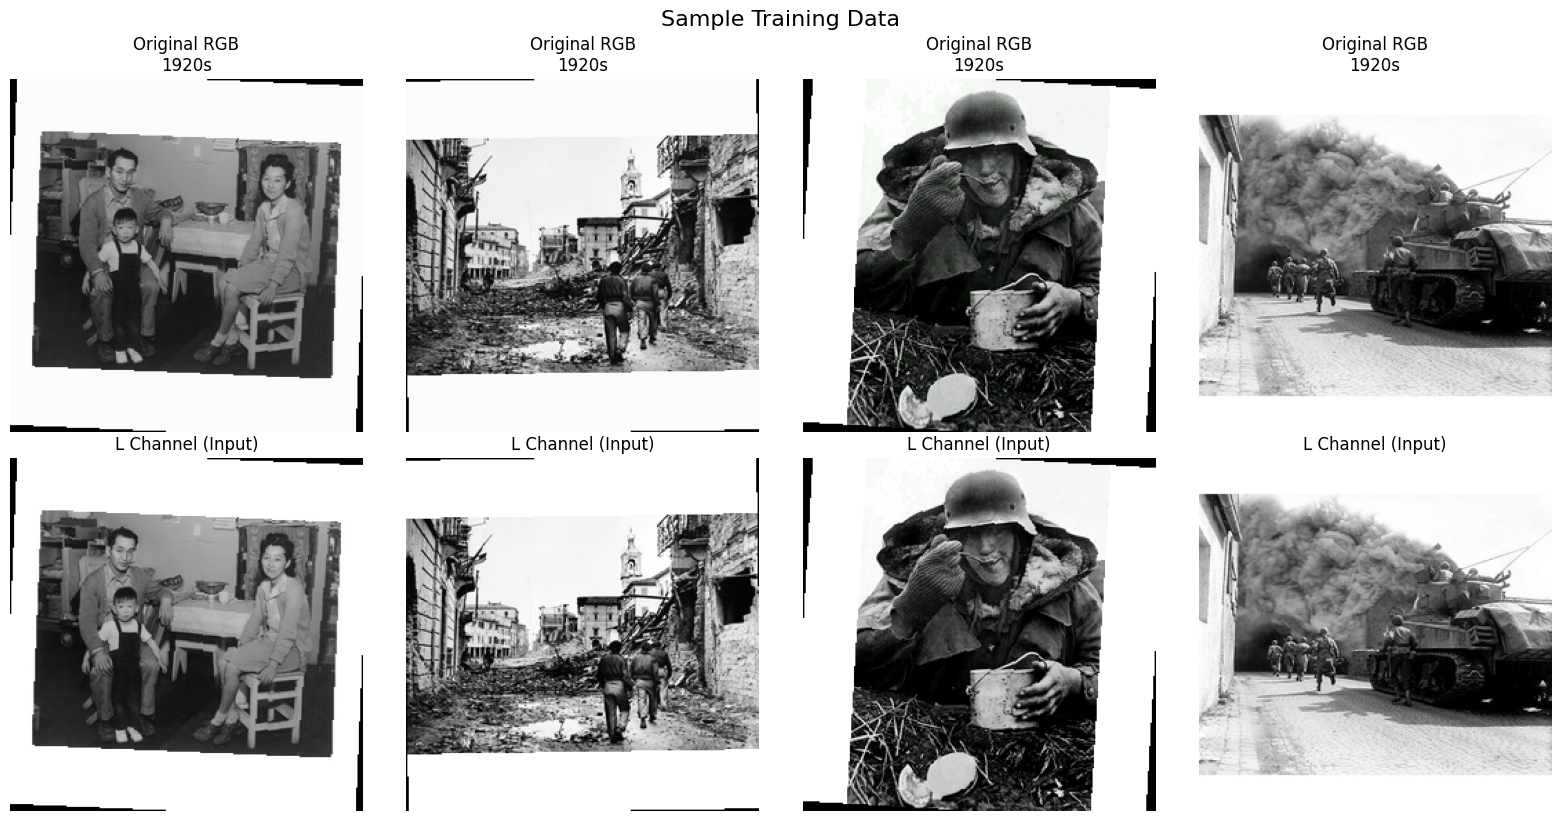

In [4]:
# =============================================================================
# CELL 3: Data Loading and Validation
# =============================================================================

print("📂 Loading datasets...")

try:
    # Create data loaders - FIXED: Now imports are available
    train_loader, val_loader = create_dataloaders(
        train_dir=config['train_data_dir'],
        val_dir=config['val_data_dir'],
        period=config['period'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        image_size=config['image_size']
    )
    
    print(f"✓ Data loaders created successfully!")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    # Test data loader
    print("\n🔍 Testing data loader...")
    sample_batch = next(iter(train_loader))
    print(f"Batch keys: {sample_batch.keys()}")
    print(f"L channel shape: {sample_batch['L'].shape}")
    print(f"AB channels shape: {sample_batch['ab'].shape}")
    print(f"RGB shape: {sample_batch['rgb'].shape}")
    print(f"Periods: {sample_batch['period'][:3]}...")  # Show first 3
    
    # Visualize sample batch
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(min(4, config['batch_size'])):
        # Original RGB
        rgb_img = sample_batch['rgb'][i].permute(1, 2, 0).cpu().numpy()
        axes[0, i].imshow(rgb_img)
        axes[0, i].set_title(f'Original RGB\n{sample_batch["period"][i]}')
        axes[0, i].axis('off')
        
        # L channel (grayscale input)
        l_channel = sample_batch['L'][i].squeeze().cpu().numpy()
        l_denorm = (l_channel + 1.0) * 50.0  # Denormalize for display
        axes[1, i].imshow(l_denorm, cmap='gray')
        axes[1, i].set_title('L Channel (Input)')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Training Data', fontsize=16, y=1.02)
    plt.show()
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure your data directories contain images:")
    print(f"Training: {config['train_data_dir']}")
    print(f"Validation: {config['val_data_dir']}")
    raise


In [5]:
# =============================================================================
# CELL 4: Model Creation and Architecture Summary
# =============================================================================

print("🔧 Creating model...")

# Create model - FIXED: Now create_model is imported
model = create_model(
    device=device,
    use_period_embedding=config['use_period_embedding']
)

print(f"✓ Model created successfully!")

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 MODEL ARCHITECTURE SUMMARY")
print("=" * 40)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024**2:.2f} MB")  # Assuming float32

# Test forward pass
print("\n🧪 Testing forward pass...")
with torch.no_grad():
    sample_L = sample_batch['L'][:2].to(device)  # Take 2 samples
    sample_periods = sample_batch['period'][:2]
    
    model.eval()
    output = model(sample_L, sample_periods)
    print(f"Input shape: {sample_L.shape}")
    print(f"Output shape: {output.shape}")
    print("✓ Forward pass successful!")


🔧 Creating model...
Model created with 18,458,434 trainable parameters
✓ Model created successfully!

📊 MODEL ARCHITECTURE SUMMARY
Total parameters: 18,458,434
Trainable parameters: 18,458,434
Model size: 70.41 MB

🧪 Testing forward pass...
Input shape: torch.Size([2, 1, 256, 256])
Output shape: torch.Size([2, 2, 256, 256])
✓ Forward pass successful!


In [6]:
# =============================================================================
# CELL 5: Training Setup (Loss, Optimizer, Scheduler)
# =============================================================================

print("⚙️ Setting up training components...")

# Loss function
criterion = ColorizationLoss(
    alpha=config['loss_alpha'],
    beta=config['loss_beta']
)

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=config['lr_step_size'],
    gamma=config['lr_gamma']
)

# Tensorboard writer
writer = SummaryWriter(config['log_dir'])

print("✓ Training components ready!")
print(f"Loss function: ColorizationLoss (α={config['loss_alpha']}, β={config['loss_beta']})")
print(f"Optimizer: Adam (lr={config['learning_rate']}, wd={config['weight_decay']})")
print(f"Scheduler: StepLR (step={config['lr_step_size']}, γ={config['lr_gamma']})")

⚙️ Setting up training components...
✓ Training components ready!
Loss function: ColorizationLoss (α=1.0, β=0.1)
Optimizer: Adam (lr=0.001, wd=1e-05)
Scheduler: StepLR (step=20, γ=0.5)


In [7]:
# =============================================================================
# CELL 6: Training Functions
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, epoch, device, writer):
    """Train for one epoch"""
    model.train()
    
    epoch_loss = 0.0
    epoch_l1_loss = 0.0
    epoch_smooth_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move data to device
        L_channel = batch['L'].to(device)
        ab_target = batch['ab'].to(device)
        period_labels = batch['period']
        
        # Forward pass
        ab_pred = model(L_channel, period_labels)
        
        # Calculate loss
        total_loss, l1_loss, smooth_loss = criterion(ab_pred, ab_target)
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Accumulate losses
        epoch_loss += total_loss.item()
        epoch_l1_loss += l1_loss.item()
        epoch_smooth_loss += smooth_loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'L1': f'{l1_loss.item():.4f}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
        
        # Log to tensorboard
        if batch_idx % config['log_interval'] == 0:
            global_step = epoch * len(train_loader) + batch_idx
            writer.add_scalar('Train/Batch_Loss', total_loss.item(), global_step)
            writer.add_scalar('Train/Batch_L1_Loss', l1_loss.item(), global_step)
            writer.add_scalar('Train/Batch_Smooth_Loss', smooth_loss.item(), global_step)
    
    # Calculate average losses
    avg_loss = epoch_loss / len(train_loader)
    avg_l1 = epoch_l1_loss / len(train_loader)
    avg_smooth = epoch_smooth_loss / len(train_loader)
    
    return avg_loss, avg_l1, avg_smooth

def validate_epoch(model, val_loader, criterion, epoch, device, config):
    """Validate for one epoch"""
    model.eval()
    
    epoch_loss = 0.0
    epoch_l1_loss = 0.0
    epoch_smooth_loss = 0.0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move data to device
            L_channel = batch['L'].to(device)
            ab_target = batch['ab'].to(device)
            period_labels = batch['period']
            
            # Forward pass
            ab_pred = model(L_channel, period_labels)
            
            # Calculate loss
            total_loss, l1_loss, smooth_loss = criterion(ab_pred, ab_target)
            
            # Accumulate losses
            epoch_loss += total_loss.item()
            epoch_l1_loss += l1_loss.item()
            epoch_smooth_loss += smooth_loss.item()
            
            progress_bar.set_postfix({'Val Loss': f'{total_loss.item():.4f}'})
            
            # Save sample results from first batch
            if batch_idx == 0:
                save_sample_colorizations(batch, ab_pred, epoch, config)
    
    # Calculate average losses
    avg_loss = epoch_loss / len(val_loader)
    avg_l1 = epoch_l1_loss / len(val_loader)
    avg_smooth = epoch_smooth_loss / len(val_loader)
    
    return avg_loss, avg_l1, avg_smooth

def save_sample_colorizations(batch, ab_pred, epoch, config):
    """Save sample colorization results - FIXED VERSION"""
    # Take first image from batch
    L_channel = batch['L'][0]          # [1, H, W]
    ab_target = batch['ab'][0]         # [2, H, W] - FIXED: Added [0]
    ab_prediction = ab_pred[0]         # [2, H, W] - FIXED: Added [0]
    original_rgb = batch['rgb'][0]     # [3, H, W] - FIXED: Added [0]
    period = batch['period'][0]        # String - FIXED: Added [0]
    
    # Move to CPU and denormalize
    L_channel = L_channel.cpu()
    ab_target = ab_target.cpu()
    ab_prediction = ab_prediction.cpu()
    original_rgb = original_rgb.cpu()
    
    # Denormalize
    L_denorm = (L_channel + 1.0) * 50.0
    ab_target_denorm = ab_target * 128.0
    ab_pred_denorm = ab_prediction * 128.0
    
    # Create LAB images
    lab_target = torch.cat([L_denorm, ab_target_denorm], dim=0)
    lab_pred = torch.cat([L_denorm, ab_pred_denorm], dim=0)
    
    # Convert to RGB
    rgb_target = lab_to_rgb(lab_target)
    rgb_pred = lab_to_rgb(lab_pred)
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original/Ground truth
    axes[0].imshow(rgb_target.permute(1, 2, 0).numpy())
    axes[0].set_title('Ground Truth')        # FIXED: Proper indexing
    axes[0].axis('off')                      # FIXED: Proper indexing
    
    # Grayscale input
    axes[1].imshow(L_denorm.squeeze().numpy(), cmap='gray')  # FIXED: [1] not [11]
    axes[1].set_title('Input (Grayscale)')   # FIXED: [1] not [11]
    axes[1].axis('off')                      # FIXED: [1] not [11]
    
    # Colorized prediction
    axes[2].imshow(rgb_pred.permute(1, 2, 0).numpy())       # FIXED: [2] not [12]
    axes[2].set_title('Colorized Output')    # FIXED: [2] not [12]
    axes[2].axis('off')                      # FIXED: [2] not [12]
    
    plt.suptitle(f'Epoch {epoch+1} - Period: {period}')
    plt.tight_layout()
    
    # Save
    save_path = os.path.join(config['sample_dir'], f'epoch_{epoch+1:03d}_sample.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

print("✓ Training functions defined!")


✓ Training functions defined!


🚀 Starting training...
Training for 50 epochs

Epoch 1/50
--------------------------------------------------


Validation Epoch 1:   0%|                                                                                   | 0/1 [00:14<?, ?it/s, Val Loss=0.9723]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 46268 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.06s/it, Val Loss=0.9723]


Train Loss: 0.9552 (L1: 0.8968, Smooth: 0.5840)
Val Loss: 0.9723 (L1: 0.9723, Smooth: 0.0008)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.9723

Epoch 2/50
--------------------------------------------------


Training Epoch 2:   0%|                                                                                                      | 0/1 [00:00<?, ?it/s]D:\colorization_task2\historical-colorization\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation Epoch 2:   0%|                                                                                   | 0/1 [00:15<?, ?it/s, Val Loss=0.9699]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 43949 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.76s/it, Val Loss=0.9699]


Train Loss: 0.9390 (L1: 0.8930, Smooth: 0.4595)
Val Loss: 0.9699 (L1: 0.9697, Smooth: 0.0022)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.9699

Epoch 3/50
--------------------------------------------------


Validation Epoch 3:   0%|                                                                                   | 0/1 [00:11<?, ?it/s, Val Loss=0.9714]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 44022 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.49s/it, Val Loss=0.9714]


Train Loss: 0.9511 (L1: 0.9084, Smooth: 0.4265)
Val Loss: 0.9714 (L1: 0.9710, Smooth: 0.0043)
Learning Rate: 0.001000

Epoch 4/50
--------------------------------------------------


Validation Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.89s/it, Val Loss=0.9714]


Train Loss: 0.9284 (L1: 0.8874, Smooth: 0.4093)
Val Loss: 0.9714 (L1: 0.9709, Smooth: 0.0046)
Learning Rate: 0.001000

Epoch 5/50
--------------------------------------------------


Validation Epoch 5:   0%|                                                                                   | 0/1 [00:10<?, ?it/s, Val Loss=0.9702]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 43481 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.99s/it, Val Loss=0.9702]


Train Loss: 0.8402 (L1: 0.7980, Smooth: 0.4220)
Val Loss: 0.9702 (L1: 0.9696, Smooth: 0.0055)
Learning Rate: 0.001000


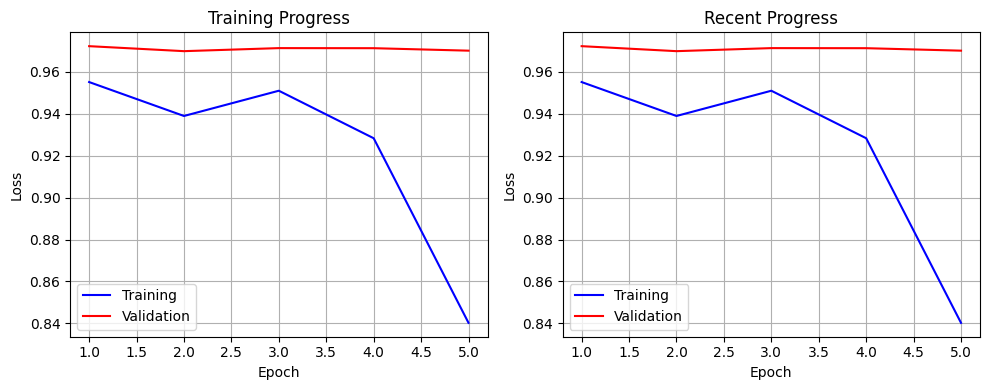


Epoch 6/50
--------------------------------------------------


Validation Epoch 6:   0%|                                                                                   | 0/1 [00:09<?, ?it/s, Val Loss=0.9682]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 43079 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.82s/it, Val Loss=0.9682]


Train Loss: 0.7970 (L1: 0.7529, Smooth: 0.4417)
Val Loss: 0.9682 (L1: 0.9667, Smooth: 0.0149)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.9682

Epoch 7/50
--------------------------------------------------


Validation Epoch 7:   0%|                                                                                   | 0/1 [00:09<?, ?it/s, Val Loss=0.8892]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33223 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.49s/it, Val Loss=0.8892]


Train Loss: 0.8057 (L1: 0.7628, Smooth: 0.4293)
Val Loss: 0.8892 (L1: 0.8839, Smooth: 0.0537)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.8892

Epoch 8/50
--------------------------------------------------


Validation Epoch 8:   0%|                                                                                   | 0/1 [00:09<?, ?it/s, Val Loss=0.8836]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 722 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it, Val Loss=0.8836]


Train Loss: 0.6925 (L1: 0.6514, Smooth: 0.4114)
Val Loss: 0.8836 (L1: 0.8756, Smooth: 0.0802)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.8836

Epoch 9/50
--------------------------------------------------


Validation Epoch 9:   0%|                                                                                   | 0/1 [00:09<?, ?it/s, Val Loss=0.7554]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 879 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.12s/it, Val Loss=0.7554]


Train Loss: 0.6258 (L1: 0.5856, Smooth: 0.4022)
Val Loss: 0.7554 (L1: 0.7433, Smooth: 0.1203)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.7554

Epoch 10/50
--------------------------------------------------


Validation Epoch 10:   0%|                                                                                  | 0/1 [00:10<?, ?it/s, Val Loss=0.7463]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2400 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.31s/it, Val Loss=0.7463]


Train Loss: 0.6372 (L1: 0.5997, Smooth: 0.3756)
Val Loss: 0.7463 (L1: 0.7337, Smooth: 0.1261)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.7463
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\checkpoint_epoch_10.pth


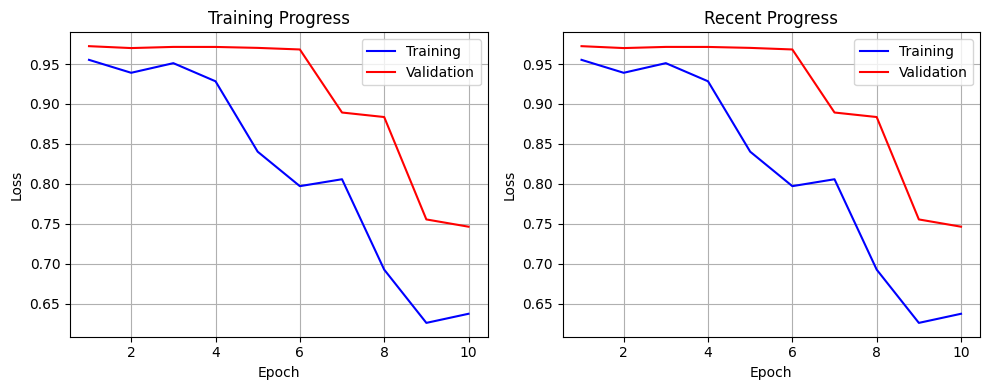


Epoch 11/50
--------------------------------------------------


Validation Epoch 11:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.6693]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2046 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.93s/it, Val Loss=0.6693]


Train Loss: 0.6580 (L1: 0.6191, Smooth: 0.3884)
Val Loss: 0.6693 (L1: 0.6562, Smooth: 0.1305)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.6693

Epoch 12/50
--------------------------------------------------


Validation Epoch 12:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.5829]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 992 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.73s/it, Val Loss=0.5829]


Train Loss: 0.5763 (L1: 0.5422, Smooth: 0.3409)
Val Loss: 0.5829 (L1: 0.5701, Smooth: 0.1280)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.5829

Epoch 13/50
--------------------------------------------------


Validation Epoch 13:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.5489]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 507 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.14s/it, Val Loss=0.5489]


Train Loss: 0.5985 (L1: 0.5645, Smooth: 0.3399)
Val Loss: 0.5489 (L1: 0.5367, Smooth: 0.1222)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.5489

Epoch 14/50
--------------------------------------------------


Validation Epoch 14:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.4972]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 371 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it, Val Loss=0.4972]


Train Loss: 0.4890 (L1: 0.4589, Smooth: 0.3009)
Val Loss: 0.4972 (L1: 0.4856, Smooth: 0.1163)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.4972

Epoch 15/50
--------------------------------------------------


Validation Epoch 15:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.4960]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 260 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.82s/it, Val Loss=0.4960]


Train Loss: 0.4593 (L1: 0.4303, Smooth: 0.2901)
Val Loss: 0.4960 (L1: 0.4842, Smooth: 0.1185)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.4960


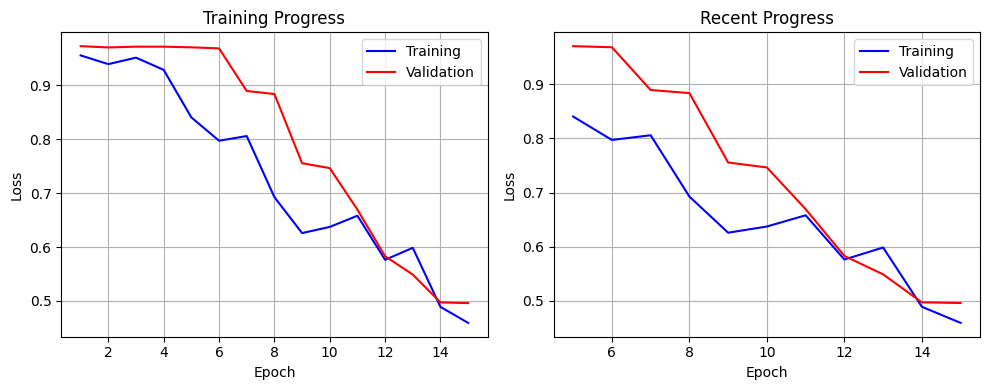


Epoch 16/50
--------------------------------------------------


Validation Epoch 16:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.4281]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 383 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.20s/it, Val Loss=0.4281]


Train Loss: 0.3500 (L1: 0.3214, Smooth: 0.2851)
Val Loss: 0.4281 (L1: 0.4155, Smooth: 0.1257)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.4281

Epoch 17/50
--------------------------------------------------


Validation Epoch 17:   0%|                                                                                  | 0/1 [00:08<?, ?it/s, Val Loss=0.3713]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 400 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.34s/it, Val Loss=0.3713]


Train Loss: 0.4083 (L1: 0.3827, Smooth: 0.2564)
Val Loss: 0.3713 (L1: 0.3590, Smooth: 0.1234)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.3713

Epoch 18/50
--------------------------------------------------


Validation Epoch 18:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.3328]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 228 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.71s/it, Val Loss=0.3328]


Train Loss: 0.4295 (L1: 0.4051, Smooth: 0.2438)
Val Loss: 0.3328 (L1: 0.3219, Smooth: 0.1090)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.3328

Epoch 19/50
--------------------------------------------------


Validation Epoch 19:   0%|                                                                                  | 0/1 [00:08<?, ?it/s, Val Loss=0.3168]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 235 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.27s/it, Val Loss=0.3168]


Train Loss: 0.3882 (L1: 0.3656, Smooth: 0.2262)
Val Loss: 0.3168 (L1: 0.3064, Smooth: 0.1041)
Learning Rate: 0.001000
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.3168

Epoch 20/50
--------------------------------------------------


Validation Epoch 20:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.2903]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 191 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it, Val Loss=0.2903]


Train Loss: 0.3555 (L1: 0.3343, Smooth: 0.2116)
Val Loss: 0.2903 (L1: 0.2804, Smooth: 0.0996)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.2903
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\checkpoint_epoch_20.pth


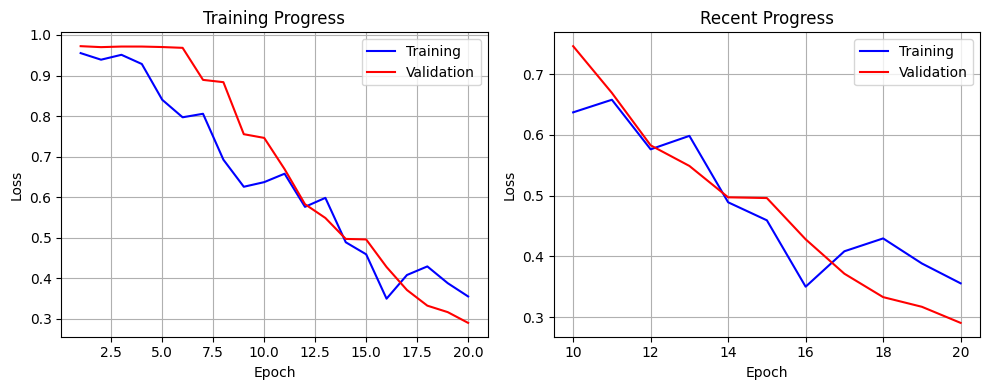


Epoch 21/50
--------------------------------------------------


Validation Epoch 21:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.2514]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 550 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.05s/it, Val Loss=0.2514]


Train Loss: 0.2909 (L1: 0.2716, Smooth: 0.1932)
Val Loss: 0.2514 (L1: 0.2400, Smooth: 0.1140)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.2514

Epoch 22/50
--------------------------------------------------


Validation Epoch 22:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.2091]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 378 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.61s/it, Val Loss=0.2091]


Train Loss: 0.2379 (L1: 0.2187, Smooth: 0.1917)
Val Loss: 0.2091 (L1: 0.2001, Smooth: 0.0897)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.2091

Epoch 23/50
--------------------------------------------------


Validation Epoch 23:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.2178]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 162 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.19s/it, Val Loss=0.2178]


Train Loss: 0.2739 (L1: 0.2551, Smooth: 0.1880)
Val Loss: 0.2178 (L1: 0.2090, Smooth: 0.0880)
Learning Rate: 0.000500

Epoch 24/50
--------------------------------------------------


Validation Epoch 24:   0%|                                                                                  | 0/1 [00:08<?, ?it/s, Val Loss=0.2212]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 154 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.07s/it, Val Loss=0.2212]


Train Loss: 0.2904 (L1: 0.2715, Smooth: 0.1887)
Val Loss: 0.2212 (L1: 0.2127, Smooth: 0.0855)
Learning Rate: 0.000500

Epoch 25/50
--------------------------------------------------


Validation Epoch 25:   0%|                                                                                  | 0/1 [00:08<?, ?it/s, Val Loss=0.2214]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 261 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.31s/it, Val Loss=0.2214]


Train Loss: 0.2752 (L1: 0.2571, Smooth: 0.1809)
Val Loss: 0.2214 (L1: 0.2128, Smooth: 0.0861)
Learning Rate: 0.000500


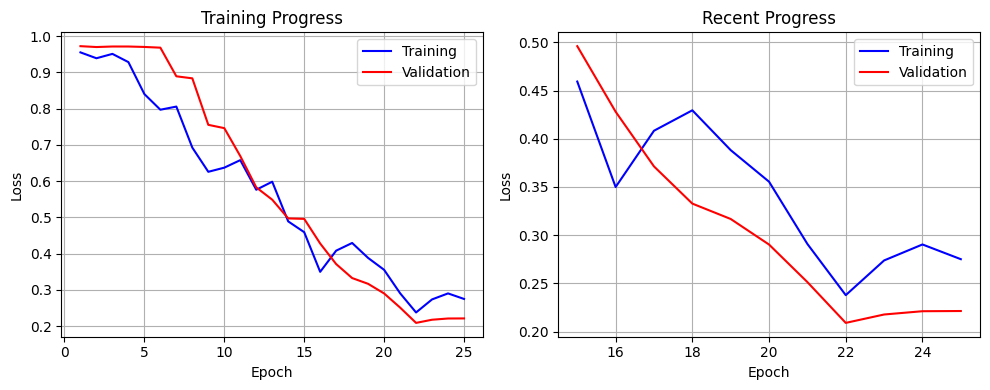


Epoch 26/50
--------------------------------------------------


Validation Epoch 26:   0%|                                                                                  | 0/1 [00:08<?, ?it/s, Val Loss=0.2175]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 149 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.53s/it, Val Loss=0.2175]


Train Loss: 0.2760 (L1: 0.2586, Smooth: 0.1739)
Val Loss: 0.2175 (L1: 0.2092, Smooth: 0.0830)
Learning Rate: 0.000500

Epoch 27/50
--------------------------------------------------


Validation Epoch 27:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.2080]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 469 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.12s/it, Val Loss=0.2080]


Train Loss: 0.2621 (L1: 0.2457, Smooth: 0.1646)
Val Loss: 0.2080 (L1: 0.1981, Smooth: 0.0989)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.2080

Epoch 28/50
--------------------------------------------------


Validation Epoch 28:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1762]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 136 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.54s/it, Val Loss=0.1762]


Train Loss: 0.2388 (L1: 0.2220, Smooth: 0.1676)
Val Loss: 0.1762 (L1: 0.1680, Smooth: 0.0820)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.1762

Epoch 29/50
--------------------------------------------------


Validation Epoch 29:   0%|                                                                                  | 0/1 [00:10<?, ?it/s, Val Loss=0.1472]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 146 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.23s/it, Val Loss=0.1472]


Train Loss: 0.2182 (L1: 0.2019, Smooth: 0.1624)
Val Loss: 0.1472 (L1: 0.1390, Smooth: 0.0814)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.1472

Epoch 30/50
--------------------------------------------------


Validation Epoch 30:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1424]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 171 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.43s/it, Val Loss=0.1424]


Train Loss: 0.1896 (L1: 0.1744, Smooth: 0.1525)
Val Loss: 0.1424 (L1: 0.1343, Smooth: 0.0805)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.1424
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\checkpoint_epoch_30.pth


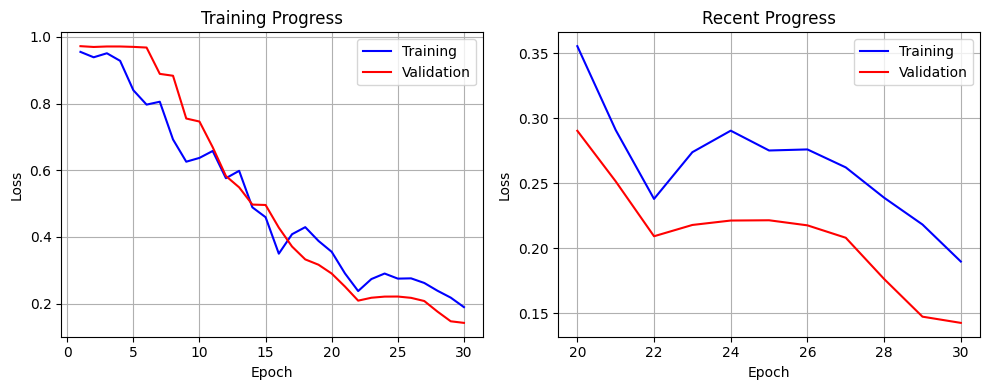


Epoch 31/50
--------------------------------------------------


Validation Epoch 31:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1409]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 205 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.61s/it, Val Loss=0.1409]


Train Loss: 0.2319 (L1: 0.2167, Smooth: 0.1516)
Val Loss: 0.1409 (L1: 0.1330, Smooth: 0.0797)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.1409

Epoch 32/50
--------------------------------------------------


Validation Epoch 32:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1206]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 64 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.99s/it, Val Loss=0.1206]


Train Loss: 0.2231 (L1: 0.2088, Smooth: 0.1435)
Val Loss: 0.1206 (L1: 0.1134, Smooth: 0.0725)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.1206

Epoch 33/50
--------------------------------------------------


Validation Epoch 33:   0%|                                                                                  | 0/1 [00:08<?, ?it/s, Val Loss=0.1457]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 597 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.50s/it, Val Loss=0.1457]


Train Loss: 0.2193 (L1: 0.2053, Smooth: 0.1400)
Val Loss: 0.1457 (L1: 0.1362, Smooth: 0.0950)
Learning Rate: 0.000500

Epoch 34/50
--------------------------------------------------


Validation Epoch 34:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1242]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 304 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.94s/it, Val Loss=0.1242]


Train Loss: 0.2042 (L1: 0.1903, Smooth: 0.1393)
Val Loss: 0.1242 (L1: 0.1163, Smooth: 0.0790)
Learning Rate: 0.000500

Epoch 35/50
--------------------------------------------------


Validation Epoch 35:   0%|                                                                                  | 0/1 [00:08<?, ?it/s, Val Loss=0.1107]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 346 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.14s/it, Val Loss=0.1107]


Train Loss: 0.1778 (L1: 0.1648, Smooth: 0.1308)
Val Loss: 0.1107 (L1: 0.1027, Smooth: 0.0794)
Learning Rate: 0.000500
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.1107


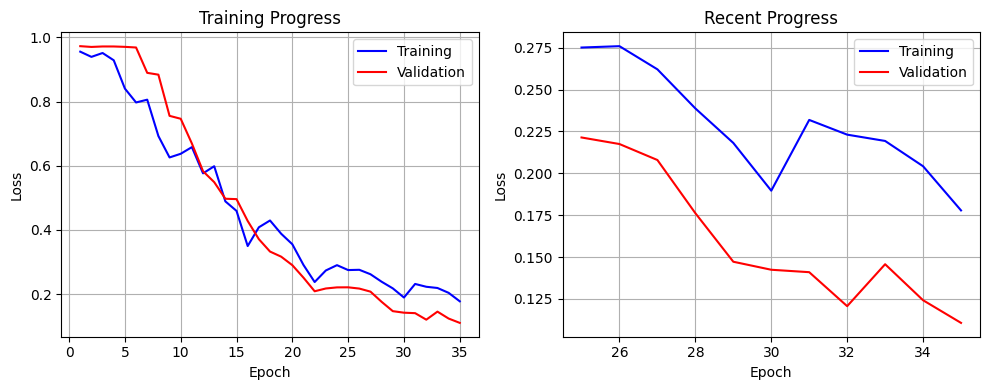


Epoch 36/50
--------------------------------------------------


Validation Epoch 36:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1208]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 273 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.46s/it, Val Loss=0.1208]


Train Loss: 0.1598 (L1: 0.1468, Smooth: 0.1296)
Val Loss: 0.1208 (L1: 0.1128, Smooth: 0.0799)
Learning Rate: 0.000500

Epoch 37/50
--------------------------------------------------


Validation Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.65s/it, Val Loss=0.1262]


Train Loss: 0.1601 (L1: 0.1466, Smooth: 0.1353)
Val Loss: 0.1262 (L1: 0.1180, Smooth: 0.0813)
Learning Rate: 0.000500

Epoch 38/50
--------------------------------------------------


Validation Epoch 38:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1393]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 198 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.38s/it, Val Loss=0.1393]


Train Loss: 0.1720 (L1: 0.1596, Smooth: 0.1237)
Val Loss: 0.1393 (L1: 0.1298, Smooth: 0.0948)
Learning Rate: 0.000500

Epoch 39/50
--------------------------------------------------


Validation Epoch 39:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.1165]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 88 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.77s/it, Val Loss=0.1165]


Train Loss: 0.1730 (L1: 0.1603, Smooth: 0.1264)
Val Loss: 0.1165 (L1: 0.1085, Smooth: 0.0802)
Learning Rate: 0.000500

Epoch 40/50
--------------------------------------------------


Validation Epoch 40:   0%|                                                                                  | 0/1 [00:11<?, ?it/s, Val Loss=0.0952]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 118 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.71s/it, Val Loss=0.0952]


Train Loss: 0.1671 (L1: 0.1548, Smooth: 0.1228)
Val Loss: 0.0952 (L1: 0.0875, Smooth: 0.0772)
Learning Rate: 0.000250
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.0952
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\checkpoint_epoch_40.pth


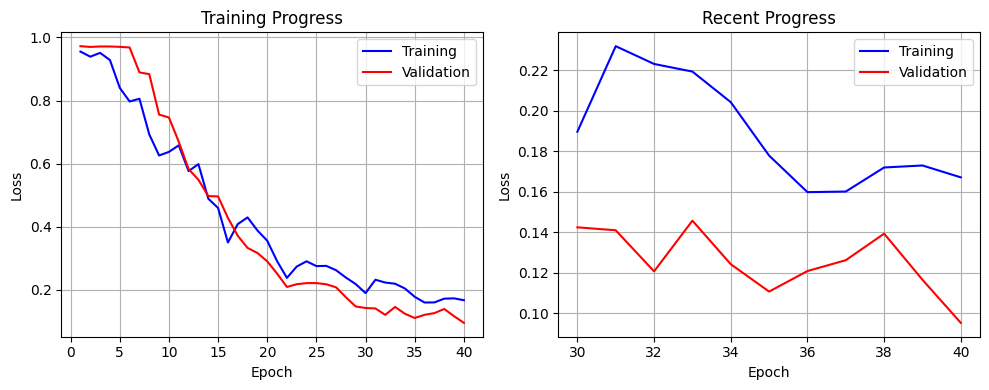


Epoch 41/50
--------------------------------------------------


Validation Epoch 41:   0%|                                                                                  | 0/1 [00:13<?, ?it/s, Val Loss=0.1006]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 22 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.70s/it, Val Loss=0.1006]


Train Loss: 0.1354 (L1: 0.1237, Smooth: 0.1170)
Val Loss: 0.1006 (L1: 0.0926, Smooth: 0.0796)
Learning Rate: 0.000250

Epoch 42/50
--------------------------------------------------


Validation Epoch 42:   0%|                                                                                  | 0/1 [00:10<?, ?it/s, Val Loss=0.1131]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 142 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.10s/it, Val Loss=0.1131]


Train Loss: 0.1241 (L1: 0.1123, Smooth: 0.1180)
Val Loss: 0.1131 (L1: 0.1040, Smooth: 0.0913)
Learning Rate: 0.000250

Epoch 43/50
--------------------------------------------------


Validation Epoch 43:   0%|                                                                                  | 0/1 [00:10<?, ?it/s, Val Loss=0.0923]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.08s/it, Val Loss=0.0923]


Train Loss: 0.1187 (L1: 0.1074, Smooth: 0.1128)
Val Loss: 0.0923 (L1: 0.0845, Smooth: 0.0781)
Learning Rate: 0.000250
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.0923

Epoch 44/50
--------------------------------------------------


Validation Epoch 44:   0%|                                                                                  | 0/1 [00:10<?, ?it/s, Val Loss=0.0813]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 100 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it, Val Loss=0.0813]


Train Loss: 0.1229 (L1: 0.1112, Smooth: 0.1170)
Val Loss: 0.0813 (L1: 0.0735, Smooth: 0.0779)
Learning Rate: 0.000250
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.0813

Epoch 45/50
--------------------------------------------------


Validation Epoch 45:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.0877]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.85s/it, Val Loss=0.0877]


Train Loss: 0.1184 (L1: 0.1073, Smooth: 0.1116)
Val Loss: 0.0877 (L1: 0.0799, Smooth: 0.0776)
Learning Rate: 0.000250


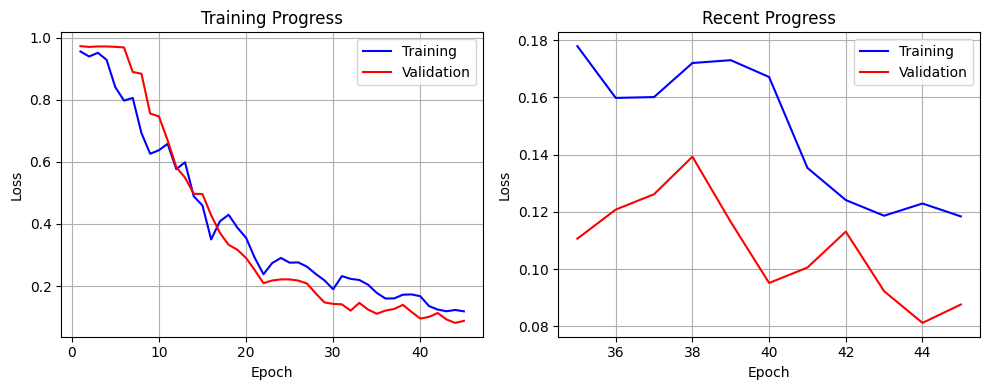


Epoch 46/50
--------------------------------------------------


Validation Epoch 46:   0%|                                                                                  | 0/1 [00:12<?, ?it/s, Val Loss=0.0813]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 14 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.10s/it, Val Loss=0.0813]


Train Loss: 0.1157 (L1: 0.1048, Smooth: 0.1092)
Val Loss: 0.0813 (L1: 0.0735, Smooth: 0.0780)
Learning Rate: 0.000250

Epoch 47/50
--------------------------------------------------


Validation Epoch 47:   0%|                                                                                  | 0/1 [00:10<?, ?it/s, Val Loss=0.0833]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 145 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.01s/it, Val Loss=0.0833]


Train Loss: 0.1138 (L1: 0.1021, Smooth: 0.1172)
Val Loss: 0.0833 (L1: 0.0747, Smooth: 0.0859)
Learning Rate: 0.000250

Epoch 48/50
--------------------------------------------------


Validation Epoch 48:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.0836]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 398 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.84s/it, Val Loss=0.0836]


Train Loss: 0.1005 (L1: 0.0902, Smooth: 0.1025)
Val Loss: 0.0836 (L1: 0.0749, Smooth: 0.0873)
Learning Rate: 0.000250

Epoch 49/50
--------------------------------------------------


Validation Epoch 49:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.0923]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 373 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.08s/it, Val Loss=0.0923]


Train Loss: 0.1078 (L1: 0.0964, Smooth: 0.1138)
Val Loss: 0.0923 (L1: 0.0824, Smooth: 0.0993)
Learning Rate: 0.000250

Epoch 50/50
--------------------------------------------------


Validation Epoch 50:   0%|                                                                                  | 0/1 [00:09<?, ?it/s, Val Loss=0.0792]D:\colorization_task2\historical-colorization\colorization\notebooks\..\src\utils.py:52: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 482 negative Z values that have been clipped to zero
  rgb_np = color.lab2rgb(lab_np)
Validation Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.65s/it, Val Loss=0.0792]


Train Loss: 0.0982 (L1: 0.0878, Smooth: 0.1041)
Val Loss: 0.0792 (L1: 0.0701, Smooth: 0.0912)
Learning Rate: 0.000250
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
✓ Best model saved! Val Loss: 0.0792
Checkpoint saved: D:/colorization_task2/historical-colorization/colorization/checkpoints\checkpoint_epoch_50.pth


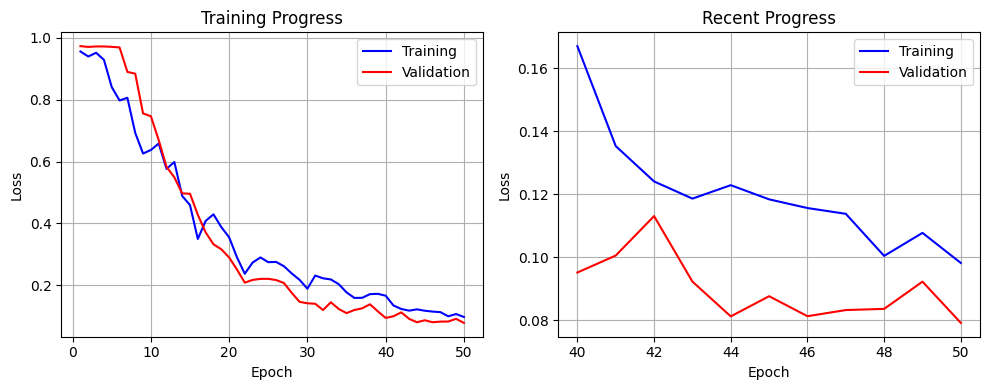


✅ Training completed!
Total training time: 0.53 hours
Best validation loss: 0.0792
Final model saved to: D:/colorization_task2/historical-colorization/colorization/models\final_model.pth


In [8]:
# =============================================================================
# CELL 7: Main Training Loop
# =============================================================================

print("🚀 Starting training...")
print(f"Training for {config['num_epochs']} epochs")

# Training tracking
train_losses = []
val_losses = []
best_val_loss = float('inf')
start_time = time.time()

try:
    for epoch in range(config['num_epochs']):
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
        print("-" * 50)
        
        # Training
        train_loss, train_l1, train_smooth = train_epoch(
            model, train_loader, criterion, optimizer, epoch, device, writer
        )
        
        # Validation
        val_loss, val_l1, val_smooth = validate_epoch(
            model, val_loader, criterion, epoch, device, config
        )
        
        # Learning rate step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Record losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log to tensorboard
        writer.add_scalar('Epoch/Train_Loss', train_loss, epoch)
        writer.add_scalar('Epoch/Val_Loss', val_loss, epoch)
        writer.add_scalar('Epoch/Learning_Rate', current_lr, epoch)
        
        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} (L1: {train_l1:.4f}, Smooth: {train_smooth:.4f})")
        print(f"Val Loss: {val_loss:.4f} (L1: {val_l1:.4f}, Smooth: {val_smooth:.4f})")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(config['checkpoint_dir'], 'best_model.pth')
            save_checkpoint(model, optimizer, epoch, val_loss, best_model_path)
            print(f"✓ Best model saved! Val Loss: {val_loss:.4f}")
        
        # Save regular checkpoint
        if (epoch + 1) % config['checkpoint_interval'] == 0:
            checkpoint_path = os.path.join(config['checkpoint_dir'], f'checkpoint_epoch_{epoch+1}.pth')
            save_checkpoint(model, optimizer, epoch, val_loss, checkpoint_path)
        
        # Plot training progress every few epochs
        if (epoch + 1) % 5 == 0:
            plt.figure(figsize=(10, 4))
            
            plt.subplot(1, 2, 1)
            plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training')
            plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Progress')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(1, 2, 2)
            recent_epochs = max(1, len(train_losses) - 10)
            plt.plot(range(recent_epochs, len(train_losses) + 1), 
                    train_losses[recent_epochs-1:], 'b-', label='Training')
            plt.plot(range(recent_epochs, len(val_losses) + 1), 
                    val_losses[recent_epochs-1:], 'r-', label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Recent Progress')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()

except KeyboardInterrupt:
    print("\n⏹️ Training interrupted by user")
    
except Exception as e:
    print(f"\n❌ Training error: {e}")
    raise

finally:
    # Training completed
    total_time = time.time() - start_time
    print(f"\n✅ Training completed!")
    print(f"Total training time: {total_time/3600:.2f} hours")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    # Close tensorboard writer
    writer.close()
    
    # Save final model
    final_model_path = os.path.join(config['models_dir'], 'final_model.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }, final_model_path)
    
    print(f"Final model saved to: {final_model_path}")


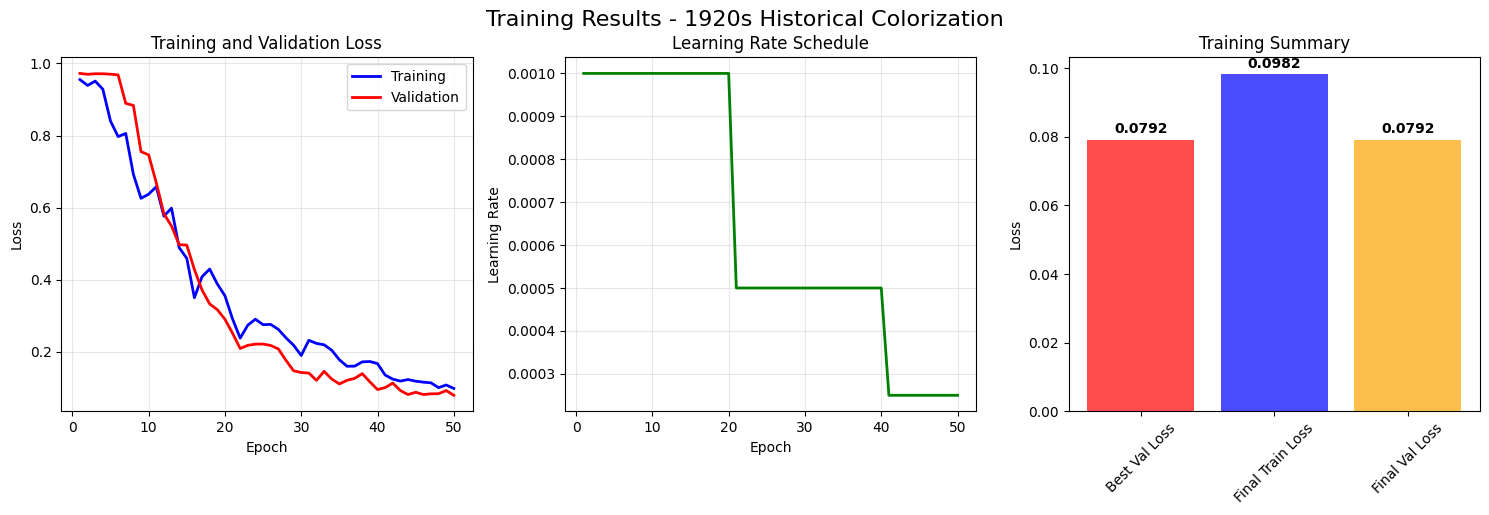


📊 TRAINING SUMMARY
Historical Period: 1920s
Total Epochs: 50
Final Training Loss: 0.0982
Final Validation Loss: 0.0792
Best Validation Loss: 0.0792
Training Time: 0.53 hours
Final Learning Rate: 0.000250

Model files saved:
- Best model: D:/colorization_task2/historical-colorization/colorization/checkpoints\best_model.pth
- Final model: D:/colorization_task2/historical-colorization/colorization/models\final_model.pth
- Sample outputs: D:/colorization_task2/historical-colorization/colorization/outputs/samples

✅ TRAINING NOTEBOOK COMPLETE!


In [9]:
# =============================================================================
# CELL 8: Training Results Visualization
# =============================================================================

# Plot final training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training', linewidth=2)
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate over time
lr_values = [config['learning_rate'] * (config['lr_gamma'] ** (epoch // config['lr_step_size'])) 
            for epoch in range(len(train_losses))]
plt.subplot(1, 3, 2)
plt.plot(range(1, len(lr_values) + 1), lr_values, 'g-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)

# Training summary stats
plt.subplot(1, 3, 3)
stats_labels = ['Best Val Loss', 'Final Train Loss', 'Final Val Loss']
stats_values = [best_val_loss, train_losses[-1], val_losses[-1]]
colors = ['red', 'blue', 'orange']
bars = plt.bar(stats_labels, stats_values, color=colors, alpha=0.7)
plt.ylabel('Loss')
plt.title('Training Summary')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, stats_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
            f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle(f'Training Results - {config["period"]} Historical Colorization', 
            fontsize=16, y=1.02)
plt.show()

print("\n📊 TRAINING SUMMARY")
print("=" * 50)
print(f"Historical Period: {config['period']}")
print(f"Total Epochs: {len(train_losses)}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Training Time: {total_time/3600:.2f} hours")
print(f"Final Learning Rate: {lr_values[-1]:.6f}")
print("\nModel files saved:")
print(f"- Best model: {os.path.join(config['checkpoint_dir'], 'best_model.pth')}")
print(f"- Final model: {final_model_path}")
print(f"- Sample outputs: {config['sample_dir']}")

print("\n✅ TRAINING NOTEBOOK COMPLETE!")